# **Face Expression Detection Using EfficientNetB2**

In [26]:
!pip install pydot


In [35]:
!pip install pydot graphviz


In [61]:
!pip install keras-visualizer


**Import Libraries**

In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
import cv2
from keras_visualizer import visualizer


In [58]:
tf.random.set_seed(4)


**Load and Preprocess Dataset**

In [4]:
# Creating the Pathlib PATH objects
train_path =Path("./images/train")
test_path =Path("./images/validation")


In [5]:
train_image_paths = list(map(lambda x: x.as_posix(), train_path.glob("*/*")))
train_image_paths[:10]


['images/train/angry/0.jpg',
 'images/train/angry/1.jpg',
 'images/train/angry/10.jpg',
 'images/train/angry/10002.jpg',
 'images/train/angry/10016.jpg',
 'images/train/angry/10037.jpg',
 'images/train/angry/10038.jpg',
 'images/train/angry/10057.jpg',
 'images/train/angry/10063.jpg',
 'images/train/angry/10069.jpg']

In [6]:
def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

##convert it into vectorized way
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)


In [7]:
Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)


In [8]:
classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)


{0: 1.813953488372093, 1: 16.065671641791045, 2: 1.758248938255472, 3: 1.0, 4: 1.4425087108013936, 5: 1.450282942603072, 6: 2.2166392092257}


In [9]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label


In [10]:
IMG_SIZE = 96 
BATCH_SIZE = 32


In [11]:
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)          
])


In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, -0.05))
])


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset


In [14]:
train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)


(32, 96, 96, 3)
(32, 7)


angry


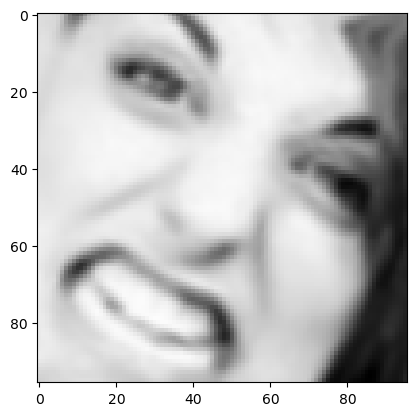

In [15]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))


In [16]:
val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)


(32, 96, 96, 3)
(32, 7)


neutral


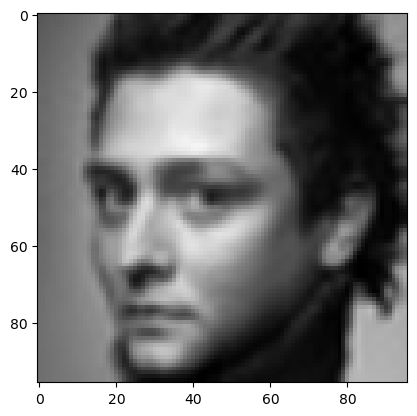

In [17]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))


**Perform Transfer Learning on EfficientNetB2 Model**

We will add custom layers on top of the EfficientNetB2 model

In [18]:
backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 3, 3, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,966,336 (30.39 MB)

 Trainable params: 7,898,761 (30.13 MB)

 Non-trainable params: 67,575 (263.97 KB)

**Compile Model**

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)


**Train Model**

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        steps_per_epoch=len(Train_paths)//BATCH_SIZE,
        epochs=50,
        validation_data=val_dataset,
        validation_steps = len(Val_paths)//BATCH_SIZE,
        class_weight=class_weight
    )


Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 951s 1s/step - accuracy: 0.2973 - loss: 3.1560 - precision: 0.6102 - recall: 0.0817 - val_accuracy: 0.4107 - val_loss: 1.5584 - val_precision: 0.6001 - val_recall: 0.2065
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 910s 1s/step - accuracy: 0.4465 - loss: 2.5472 - precision: 0.6873 - recall: 0.2286 - val_accuracy: 0.4684 - val_loss: 1.3813 - val_precision: 0.7727 - val_recall: 0.2194
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 673s 994ms/step - accuracy: 0.4813 - loss: 2.3786 - precision: 0.7146 - recall: 0.2712 - val_accuracy: 0.5121 - val_loss: 1.3021 - val_precision: 0.7141 - val_recall: 0.2924
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 524s 776ms/step - accuracy: 0.5052 - loss: 2.2553 - precision: 0.7200 - recall: 0.3023 - val_accuracy: 0.5470 - val_loss: 1.2032 - val_precision: 0.7415 - val_recall: 0.3531
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 522s 773ms/step - accuracy: 0.5193 - loss: 2.1961 - precision: 0.7145 - recall: 0.3133 - val_accuracy: 0.5452 

**Freeze First Layer**

In [21]:
model.layers[0].trainable = False


**Add Checkpoint and Early Stop to Optimize Model Training**

This will save the best performing model and stop training early in case of overfitting

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 3, 3, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,763,860 (90.65 MB)

 Trainable params: 197,767 (772.53 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

 Optimizer params: 15,797,524 (60.26 MB)

**Train Model**

In [23]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=20,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)


Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7780 - loss: 0.9426 - precision: 0.8346 - recall: 0.7240
Epoch 1: val_loss improved from inf to 1.11043, saving model to best_weights.weights.h5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1362s 2s/step - accuracy: 0.7780 - loss: 0.9425 - precision: 0.8346 - recall: 0.7240 - val_accuracy: 0.6421 - val_loss: 1.1104 - val_precision: 0.6913 - val_recall: 0.5864
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7718 - loss: 1.0237 - precision: 0.8288 - recall: 0.7092
Epoch 2: val_loss did not improve from 1.11043
675/675 ━━━━━━━━━━━━━━━━━━━━ 944s 1s/step - accuracy: 0.7718 - loss: 1.0237 - precision: 0.8288 - recall: 0.7092 - val_accuracy: 0.6299 - val_loss: 1.1475 - val_precision: 0.6898 - val_recall: 0.5686
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.7899 - loss: 0.9169 - precision: 0.8453 - recall: 0.7287
Epoch 3: val_loss did not improve from 1.11043
675/675 ━━━━━━━━━━━━━━━━━━━━ 581s 861ms/step - a

**Visualize Model Architecture**

In [59]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


**Plot Accuracy and Loss**

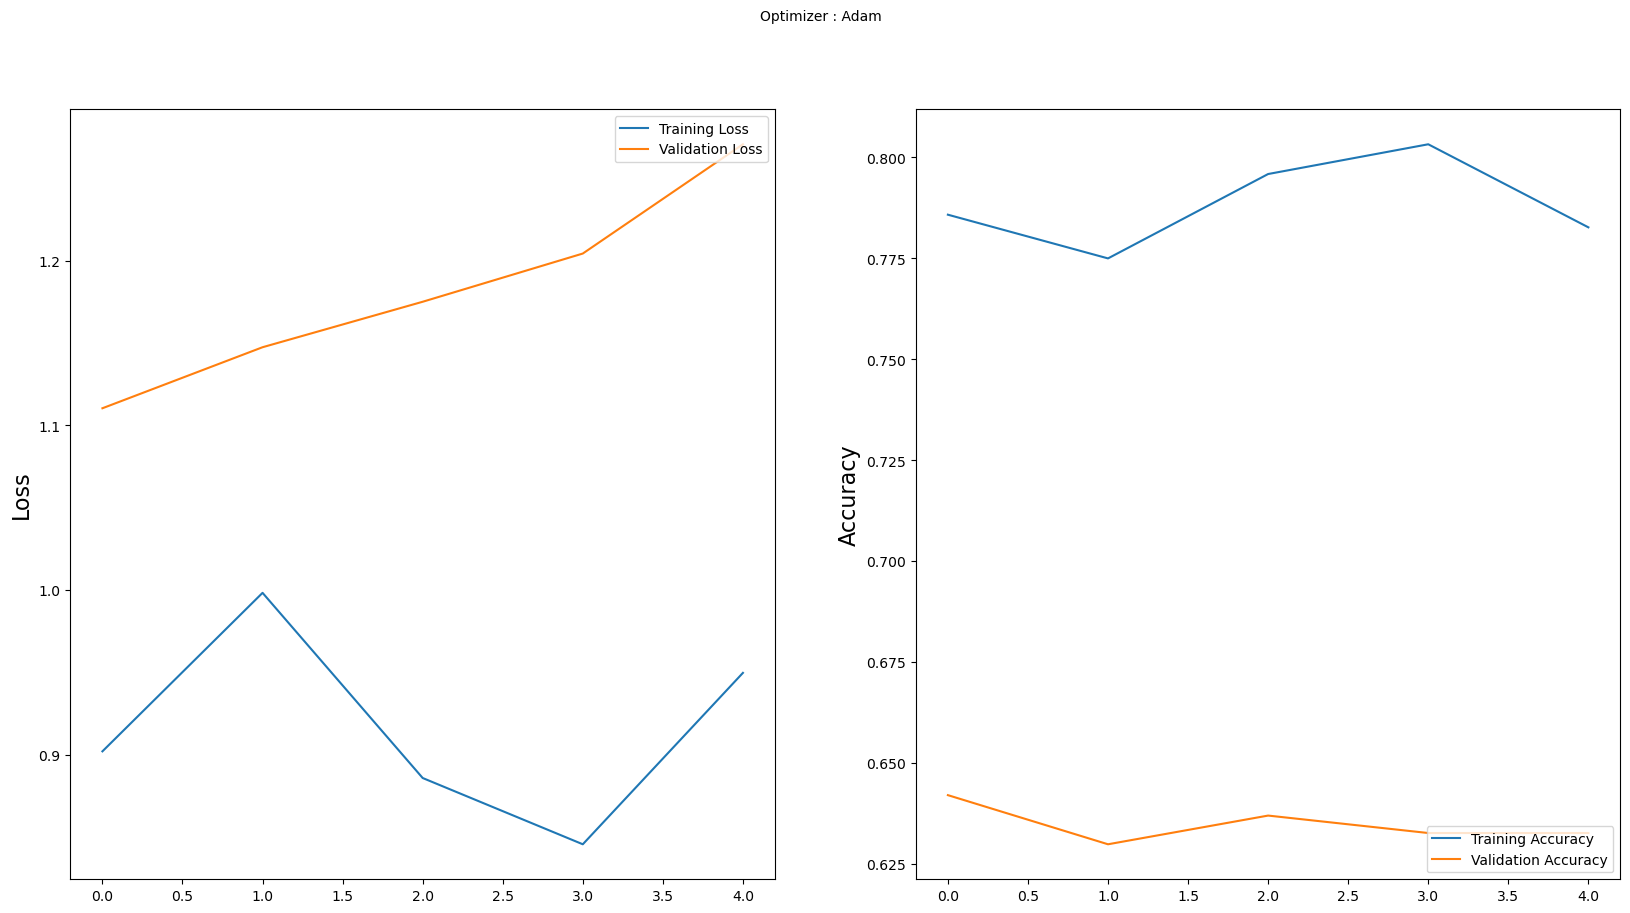

In [70]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
 

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
 
plt.show()


**Load Model Weights**

In [72]:
model.load_weights("best_weights.weights.h5")


**Preprocess Test Dataset**

In [83]:
test_image_paths = list(map(lambda x: x.as_posix(), test_path.glob("*/*")))
test_image_paths[:10]


['images/validation/angry/10052.jpg',
 'images/validation/angry/10065.jpg',
 'images/validation/angry/10079.jpg',
 'images/validation/angry/10095.jpg',
 'images/validation/angry/10121.jpg',
 'images/validation/angry/10148.jpg',
 'images/validation/angry/10163.jpg',
 'images/validation/angry/10215.jpg',
 'images/validation/angry/1024.jpg',
 'images/validation/angry/10286.jpg']

In [84]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
 
#test_image_paths = list(map(lambda x : str(x) , files))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)


In [85]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)


(32, 96, 96, 3)
(32, 7)


angry


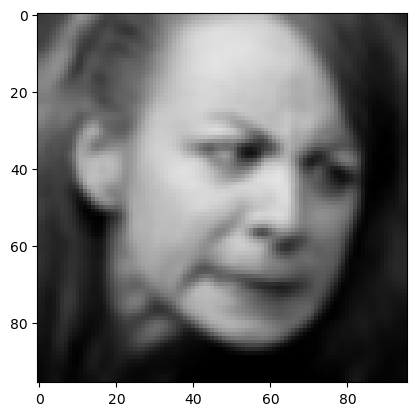

In [86]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))


**Evaluate Model on Test Dataset**

In [87]:
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)


221/221 ━━━━━━━━━━━━━━━━━━━━ 86s 386ms/step - accuracy: 0.6178 - loss: 1.1984 - precision: 0.6777 - recall: 0.5623
 Testing Acc :  0.6391168832778931
 Testing Precision  0.6949898600578308
 Testing Recall  0.5810925364494324


**Compute Predictions**

In [88]:
predictions = model.predict(test_dataset)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = np.argmax(test_labels,axis=1)
class_names =  Le.inverse_transform(y_pred)


221/221 ━━━━━━━━━━━━━━━━━━━━ 62s 256ms/step


**Visualize Confusion Matrix**

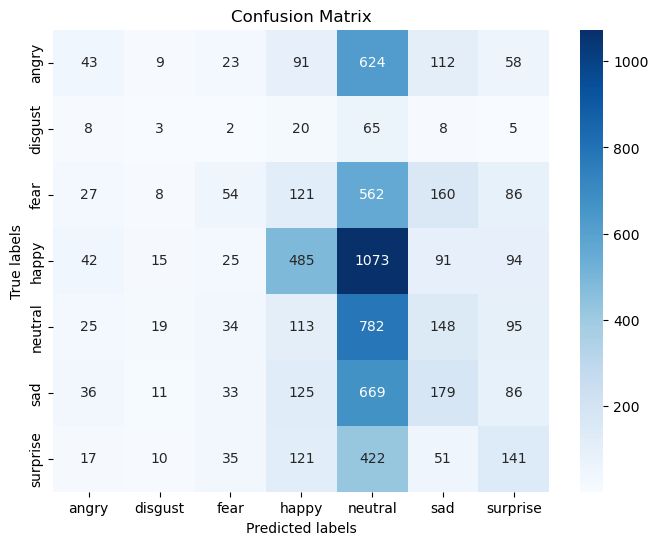

In [89]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=Le.classes_, yticklabels=Le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


**Save Objects**

In [90]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("final_best_weights.weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)


In [91]:
def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()


In [92]:
save_object(Le, "LabelEncoder")


**Load Pre-Trained Model to Detect Faces**

In [93]:
# Load the pre-trained face cascade classifier for detect face boundries
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


**Annotate Images With Face Emotion**

We will define a function that:
- Detect Faces in an image.
- Annotate detected faces on the image with bounding boxes.
- Classify detected face expression.
- Annotate faces expression on bounding boxes on the image.

In [94]:
def detect_image_emotion(image_path):
    # Read the input image
    img = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=25)

    # Check if any faces were detected
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # Adjust ROI coordinates to avoid going out of bounds
            x = max(0, x)
            y = max(0, y)
            face = img[y:y+h+150, x:x+w+150]   
            face = cv2.resize(face, (96, 96))
            face_array = np.array(face)
            face_array = np.expand_dims(face_array, axis=0)
            prediction = np.argmax(model.predict([face_array]), axis=1)
            class_ = Le.inverse_transform(prediction)[0]
            font = cv2.FONT_HERSHEY_SIMPLEX
            print(class_)
            cv2.putText(img, class_, (x, y), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    else:
        print("No faces detected in the image.")

    # Display the modified image using matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
neutral


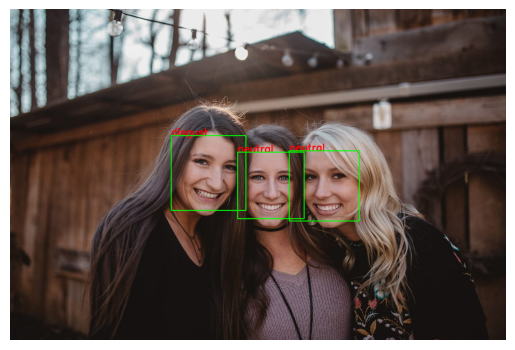

In [95]:
detect_image_emotion("./Human_Faces_Images/00000715.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
neutral


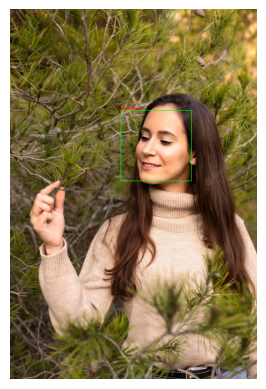

In [96]:
detect_image_emotion("./Human_Faces_Images/00000100.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
happy


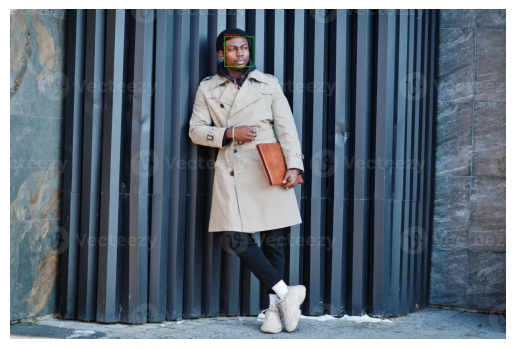

In [97]:
 detect_image_emotion("./Human_Faces_Images/00000957.jpg")
